# How to use MGS(Mulguisin)!
## This file shows how to use MGS algorithm

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import Mulguisin


In [2]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
from time import time

### Read data file. The data is random data.

In [3]:
f = h5.File("rand_gal_data_210218_sig10.hdf5",'r')
x1 = np.array(f["x_rsd"])
y1 = np.array(f["y_rsd"])
z1 = np.array(f["z_rsd"])
f.close()
print('Length of data : ',len(x1))

Length of data :  5000


### MGS calculation
##### MGS initialization
MGS provides three type of density calculations. The density calculation is necessary to run MGS and there are several types to estimate density.  
One is 'voronoi' method that calculates 3D voronoi cell and estimates density. Another one is 'local density' method that calculates density using sphere. The other one is
'weight' method that uses information about mass or brightness or etc.  
If you use MGS, you should define type of density calculation. The allowed values are '**voronoi**', '**local**' and '**weight**'.

#### Input parameters
MGS gets different input parameters by different type of density calculation.  
The common parameter is **Rcut** : linking-length

* If type of density calculation is voronoi and the data dimension is 2D, you should insert another input parameter as '**boundaries**' : [x0,x1,y0,y1]  

* If type of density calculation is local, you should insert anohter input parameter as '**radius**' : radius = 10.

* If type of density calculation is weight, you just put your weight array into '**weight**' : weight = 'your weight'.   
Note! If your weight array is already sorted, than you put into another option as **sorted = True**

#### Return values

* Nmgs : The number of MGS groups/clusters
* imgs : Index of MGS. The total length is the same as data, but it is ordered by density  
* clg : Galaxy id. 'clg' is list of list, there are galaxy ids in one cluster/group  
* clm : Mother galaxy id  
* cng : The number of member for each cluster/group  

In [4]:
mgs_init = Mulguisin.mulguisin_type('voronoi')
Rcut = 10.0
MGS = mgs_init(Rcut,x1,y1,z1)
Nmgs, imgs, clg, clm, cng = MGS.get_mgs()

Calculate Voronoi density
Calculation is done. Time =  4.321430921554565
Calculate MGS
Calculation is done. Time =  0.8896760940551758


* If you want to use 'local'

```python
mgs_init = Mulguisin.mulguisin_type('local')
Rcut = 10.0
MGS = mgs_init(Rcut,x1,y1,z1,radius=10.)
Nmgs, imgs, clg, clm, cng = MGS.get_mgs()
```

In [5]:
print('Total number of mgs : ', Nmgs)

Total number of mgs :  50


### Draw MGS cluster/group into 3D space

* MGS provides link information. It contains [mother_galaxy, children_galaxy, MGS_index]

In [8]:
links = MGS.get_link()
links

array([[1874., 1874.,    0.],
       [1874., 1898.,    0.],
       [1898., 1867.,    0.],
       ...,
       [ 973.,  918.,   49.],
       [ 959.,  956.,   49.],
       [ 956.,  911.,   49.]])

* MGS also provides label information. The label indicates that the MGS index for each data point

In [9]:
labels = MGS.get_label()
labels

array([46, 46, 46, ..., 17, 17, 17])

1. Using the label infomation, you can easily make 3D distribution of MGS groups/clusters

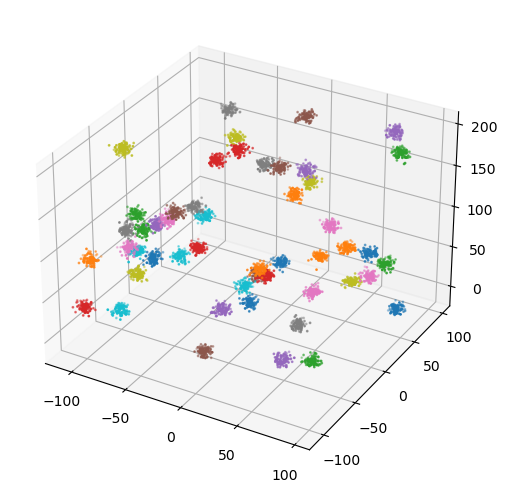

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
for i in range(Nmgs):
    ind = np.where(labels==i)[0]
    ax.scatter(x1[ind],y1[ind],z1[ind],s=1)
fig.tight_layout()

2. Using the link information, you can draw MGS structure

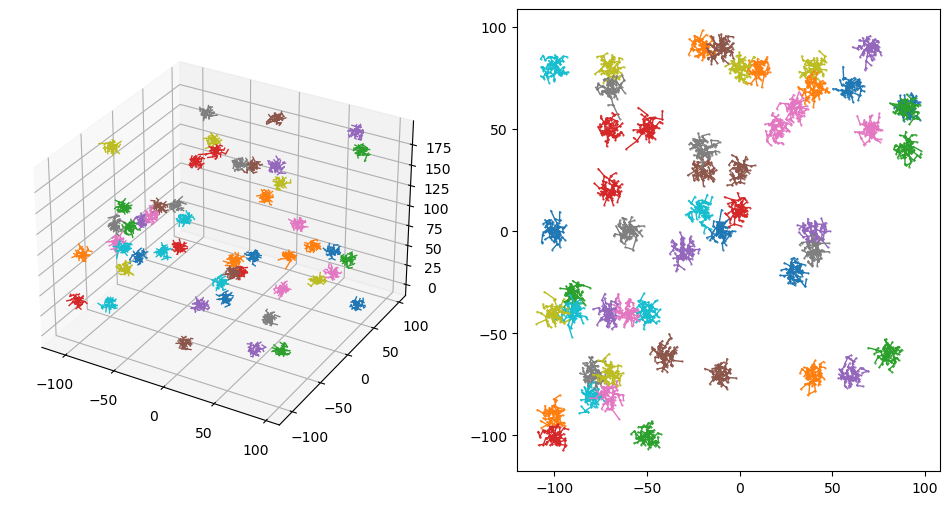

In [17]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121,projection='3d')
for i in range(Nmgs):
    for id_gals in links[links[:,2]==i]:
        id_gals = id_gals.astype(int)[:2]
        ax.plot(x1[id_gals],y1[id_gals],z1[id_gals],c='C%s'%i,lw=1,markersize=1,rasterized=True)
ax = fig.add_subplot(122)
for i in range(Nmgs):
    for id_gals in links[links[:,2]==i]:
        id_gals = id_gals.astype(int)[:2]
        ax.plot(x1[id_gals],y1[id_gals],c='C%s'%i,lw=1,marker='.',markersize=1,rasterized=True)

### Topological informations  
Now, we calculate topological informations.  
1. Total length : The sum of all distance of links in one cluster/group
2. Generation : The number of node from origin galaxy to each galaxy  
3. Length : The total length of one generation  
4. Number of children : The number of children for each galaxy  
5. Number of Degree : The number of node connected with other galaxy  
6. Number of branch : The number of branch for one cluster/group  
7. Opening angle : The angle made by three galaxies  
8. Polar angle : The angle based on observer (0,0,0)  
9. Polar angle from origin : The angle with observer and origin galaxy and other galaxy  

In [19]:
sta = time()
Totlength = []
for i in range(Nmgs):
    Totlength.append(MGS.Get_TotLength(i))

Generations = []
for i in range(Nmgs):
	for j in range(cng[i]):
		Generations.append(MGS.Get_generation(i,j))

Length = []
for i in range(Nmgs):
	for j in range(cng[i]):
		Length.append(MGS.Get_Length(i,j))

nChild = []
for i in range(Nmgs):
	for j in range(cng[i]):
		nChild.append(MGS.Get_Child(i,j))

nDegree = []
for i in range(Nmgs):
	for j in range(cng[i]):
		nDegree.append(MGS.Get_Degree(i,j))

nBranch = []
for i in range(Nmgs):
	nBranch.append(MGS.Get_Branch(i))

OpenAngle = []
for i in range(Nmgs):
	for j in range(cng[i]):
		openangle = MGS.Get_OpenAngle(i,j)
		OpenAngle.append(openangle)

PolarAngle = []
for i in range(Nmgs):
	for j in range(cng[i]):
		PolarAngle.append(MGS.Get_LinkPolarAngle(i,j))

end = time()
print('Time for calculating topological information = ', end - sta)

Time for calculating topological information =  5.767688035964966


If we cannot calculate opening angle or polar angle, we make code returning -1

In [20]:
OpenAngle = np.asarray(OpenAngle)
PolarAngle = np.asarray(PolarAngle)
mask_open = np.where(OpenAngle>=0)
mask_polar = np.where(PolarAngle>=0)

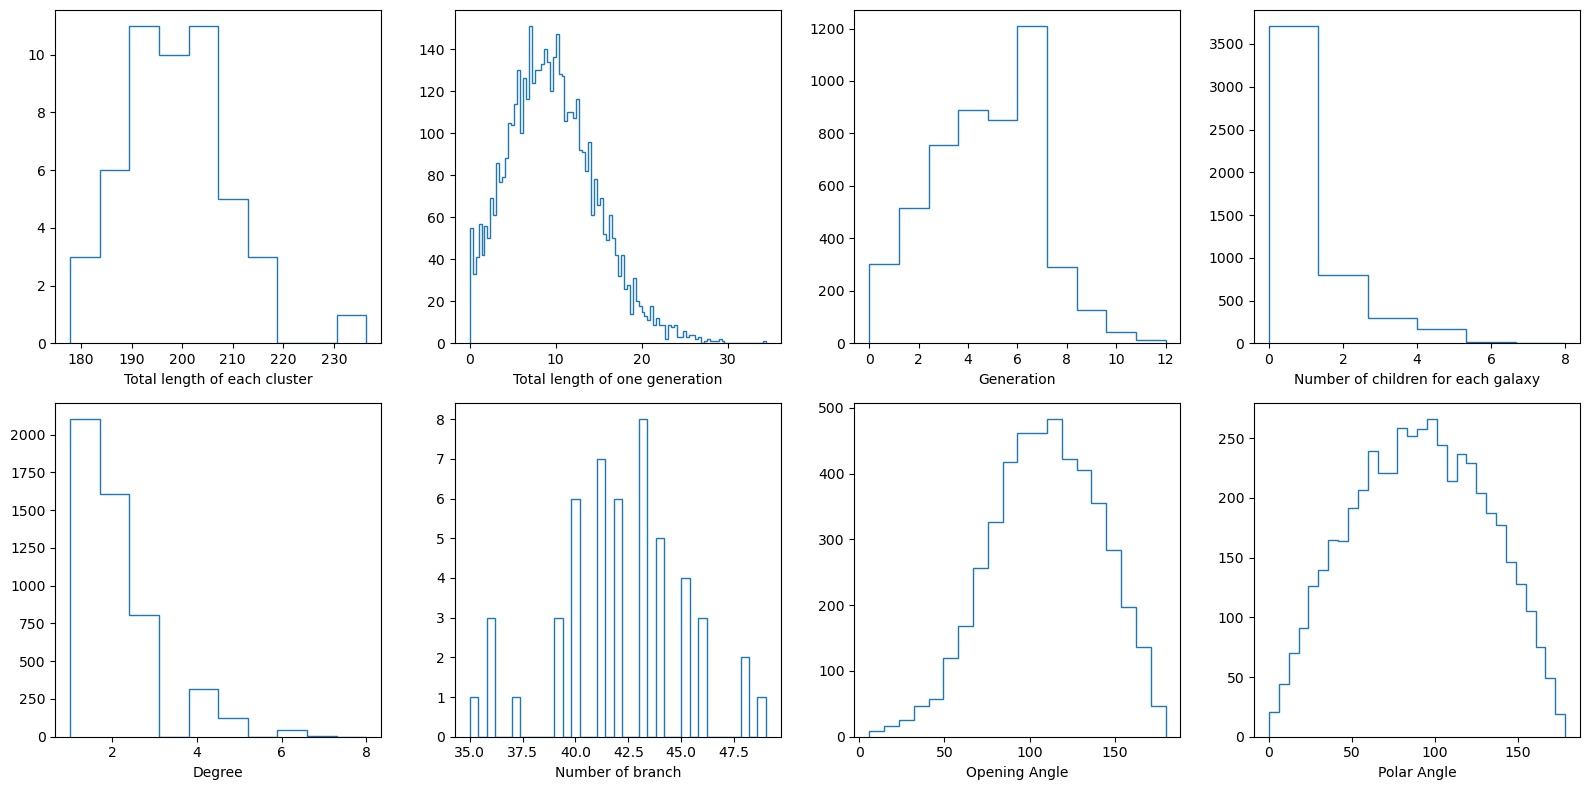

In [21]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
ax[0,0].hist(Totlength,histtype='step')
ax[0,0].set_xlabel('Total length of each cluster')
ax[0,1].hist(Length,bins=100,histtype='step')
ax[0,1].set_xlabel('Total length of one generation')
ax[0,2].hist(Generations,histtype='step')
ax[0,2].set_xlabel('Generation')
ax[0,3].hist(nChild,bins=6,histtype='step')
ax[0,3].set_xlabel('Number of children for each galaxy')
ax[1,0].hist(nDegree,histtype='step')
ax[1,0].set_xlabel('Degree')
ax[1,1].hist(nBranch,bins=35,histtype='step')
ax[1,1].set_xlabel('Number of branch')
ax[1,2].hist(OpenAngle[mask_open]*(180./np.pi),bins=20,histtype='step')
ax[1,2].set_xlabel('Opening Angle')
ax[1,3].hist(PolarAngle[mask_polar]*(180./np.pi),bins=30,histtype='step')
ax[1,3].set_xlabel('Polar Angle')

plt.tight_layout()